In [1]:
print("hello world")

The following example will show a classification task (recognizing handwritten digits through the MNIST database) and will be based off of an example from Hands On Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron

<h3>Due to mldata.org and fetch_mldata being undreliable you will have to download the file mnist-original.mat from my github (link provided below) if you wish to run it yourself, however, if possible, just don't reload the kernel when you open this and you should see everything</h3>

In [2]:
# First things first we have to get the data, I have it saved locally but I will also push it up to git 
# and request it from my own github here

import requests

# A quick test with a text file to make sure everything's in order
url = "https://raw.githubusercontent.com/mdigreg2/DataScience/master/ml/datasets/test_text"
r = requests.get(url)
print(r)

<Response [200]>


In [3]:
print(help(r))

Help on Response in module requests.models object:

class Response(builtins.object)
 |  The :class:`Response <Response>` object, which contains a
 |  server's response to an HTTP request.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if the status code of the response is between
 |      400 and 600 to see if there was a client error or a server error. If
 |      the status code, is between 200 and 400, this will return True. This
 |      is **not** a check to see if the response code is ``200 OK``.
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Allows you to use a response as an iterator.
 |  
 |  __nonzero__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if

In [4]:
print(r.text)

test text



In [5]:
print(r.content)

b'test text\n'


So as it truns out, fetch_mldata no longer works, so just download the file from my github at https://github.com/mdigreg2/DataScience/blob/master/ml/datasets/mnist_original/mnist-original.mat and then run the program. It's a huge pain to pull it fropm github because it's over 50MB and git doesn't allow fro easy viewing of the raw file

In [6]:
from scipy.io import loadmat\
# Change this path to wherever you have downloaded this file 
mnist_path = "./datasets/mnist_original/mnist-original.mat"
mnist_raw = loadmat(mnist_path)
mnist = {
    "data":mnist_raw["data"].T,
    "target":mnist_raw["label"][0],
    "COL_NAMES":["label", "data"],
    "DESCR":"remake of mldata.org's mnist-original.mat"
}
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

There are 70,000 images of digits, the images are saved in a 28x28 grid

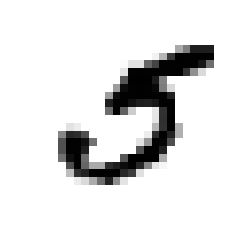

In [23]:
import matplotlib
import matplotlib.pyplot as pt

a_digit = X[36000]
a_digit_image = a_digit.reshape(28,28)
pt.imshow(a_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
pt.axis("off")
pt.show()
